In [1]:
import sys
sys.path.append('../Modules')
import numpy as np
import pandas as pd

import galsim
from coord import radians

import Image_Fits_Stats
#import Visual_analysis

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
import pywt
from scipy.stats import norm
import math

#Galsim arguments
target_size=64
galaxy_type='real'
psf_type='real'

test_galaxies_indices=[518, 33671, 25576, 45805, 31577, 41707, 19844, 13628,  8624]

cat = galsim.COSMOSCatalog(sample='23.5')
#Pixel scale in arcsec (the same for all the galaxies)
_,_,_,pixel_scale,_=cat.getRealParams(0)

In [2]:
#Obtain galsim.GSObject for a given galaxy 
#with noise,ellipticity and rotation angle
def get_galaxy(index):
    #Making galaxy
    gal=cat.makeGalaxy(index,gal_type=galaxy_type)
    
    #Get the PSF object
    psf = gal.original_psf
    #Perform convolution with PSF to get the original HST image
    gal=galsim.Convolve(gal, psf)
    
    #Ellipticity
    COSMOS_ellipticity=cat.getParametricRecord(index)['sersicfit'][3]
    
    #Angle
    COSMOS_angle=cat.getParametricRecord(index)['sersicfit'][-1]

    #Noise
    _,_,_,_,COSMOS_noise_variance=cat.getRealParams(index)
    COSMOS_noise=np.sqrt(COSMOS_noise_variance)
    
    return gal,COSMOS_noise,COSMOS_ellipticity,COSMOS_angle

def get_rotated_gal(gal,phi):
        
    # gal.rotate turns anticlockwise, therefore we need to pass -angle
    rot_phi=galsim.Angle(-phi*radians)
    
    rotated_gal=gal.rotate(rot_phi)
    
    return rotated_gal

def get_fit_image(image,fit,profile_type='Sersic'):
    x = np.linspace(0, image.shape[1], image.shape[1])
    y = np.linspace(0, image.shape[0], image.shape[0])
    X, Y = np.meshgrid(x, y)
    # We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
    xdata = np.vstack((X.ravel(), Y.ravel()))
    
    if profile_type=='Sersic':
        return Image_Fits_Stats.Sersic_profile(xdata,*fit).reshape(image.shape)
    elif profile_type=='Chameleon_Sersic':
        return Image_Fits_Stats.Chameleon_Sersic(xdata,*fit).reshape(image.shape)
    elif profile_type=='Chameleon':
        return Image_Fits_Stats.Chameleon_profile(xdata,*fit).reshape(image.shape)
    elif profile_type=='Double_Sersic':
        return Image_Fits_Stats.Double_Sersic(xdata,*fit).reshape(image.shape)
    
'''
skimage.restoration.estimate_sigma
[1] D. L. Donoho and I. M. Johnstone. "Ideal spatial adaptation 
by wavelet shrinkage." Biometrika 81.3 (1994): 425-455.
       :DOI:`10.1093/biomet/81.3.425`
'''

def show_galaxy(test_galaxy_index):
    gal,COSMOS_noise,COSMOS_ellipticity,COSMOS_angle=get_galaxy(test_galaxy_index)
    # It turns anticlockwise, therefore we need to pass -angle
    #rot_phi=galsim.Angle(-COSMOS_angle*radians)
    rotated_image=gal.drawImage(use_true_center=True, method='auto').array
    plt.imshow(rotated_image)
    plt.show()
    return rotated_image

# Test applicability of manual noise extraction

In [3]:
Labels=pd.read_csv('Test data/Labels_0_50932_old.csv',index_col=1).drop('Unnamed: 0',axis=1)
Labels.head()

,COSMOS_Bulge_HLR,COSMOS_Bulge_I,COSMOS_Bulge_n,COSMOS_Bulge_phi,COSMOS_Bulge_q,COSMOS_Bulge_x0,COSMOS_Bulge_y0,COSMOS_Disk_HLR,COSMOS_Disk_I,COSMOS_Disk_n,...,Sersic_y0_err,mag_auto,max_I,min_I,zphot,SNR,SNR_COSMOS,COSMOS_R_cut,NonUniformity,R_cut
COSMOS_index,,,,,,,,,,,,,,,,,,,,,
0,13.600641,0.004279,4.0,1.698688,0.050000,247.249777,251.840007,14.759418,0.012038,1.0,...,0.140400,21.040642,0.570709,-0.037081,0.1950,53.763315,223.814253,44.901452,22.218840,27
1,0.201440,0.258925,4.0,2.009977,0.614526,177.920633,178.784481,15.099626,0.011899,1.0,...,0.123807,21.782894,0.154042,-0.016080,0.7552,38.302530,57.903729,36.048607,12.510214,28
2,0.510588,0.528859,4.0,-3.063154,0.050000,107.890388,108.379722,7.153612,0.047064,1.0,...,0.084147,22.861856,0.133911,-0.011602,0.9616,46.864650,34.559685,18.143305,25.409052,24
3,2.310266,0.000000,4.0,0.004540,0.050000,173.005949,174.406523,15.952558,0.008017,1.0,...,0.131422,22.229794,0.080922,-0.015357,0.9266,20.043728,31.663673,29.817058,9.556059,31
4,2.254391,0.022633,4.0,2.249803,0.620285,102.961122,102.482383,5.186225,0.042089,1.0,...,0.071068,23.283966,0.126981,-0.010049,0.6719,55.347211,45.456929,14.602186,33.596505,19


In [4]:
Labels.columns

Index(['COSMOS_Bulge_HLR', 'COSMOS_Bulge_I', 'COSMOS_Bulge_n',
       'COSMOS_Bulge_phi', 'COSMOS_Bulge_q', 'COSMOS_Bulge_x0',
       'COSMOS_Bulge_y0', 'COSMOS_Disk_HLR', 'COSMOS_Disk_I', 'COSMOS_Disk_n',
       'COSMOS_Disk_phi', 'COSMOS_Disk_q', 'COSMOS_Disk_x0', 'COSMOS_Disk_y0',
       'COSMOS_Sersic_HLR', 'COSMOS_Sersic_I', 'COSMOS_Sersic_n',
       'COSMOS_Sersic_phi', 'COSMOS_Sersic_q', 'COSMOS_Sersic_x0',
       'COSMOS_Sersic_y0', 'COSMOS_noise', 'COSMOS_use_bulgefit', 'IDENT',
       'Noise_mean', 'Noise_std', 'Original_R_cut', 'Original_x_size',
       'Original_y_size', 'Sersic_HLR', 'Sersic_HLR_err', 'Sersic_I',
       'Sersic_I_err', 'Sersic_n', 'Sersic_n_err', 'Sersic_phi',
       'Sersic_phi_err', 'Sersic_q', 'Sersic_q_err', 'Sersic_r_chi_sq',
       'Sersic_x0', 'Sersic_x0_err', 'Sersic_y0', 'Sersic_y0_err', 'mag_auto',
       'max_I', 'min_I', 'zphot', 'SNR', 'SNR_COSMOS', 'COSMOS_R_cut',
       'NonUniformity', 'R_cut'],
      dtype='object')

'Original_x_size','Original_y_size' represent original image size. In a turn 'Original_R_cut' and 'Original_R_cut' multiplied by 'Sersic_q' should outline the size of galaxy. All the space that is not covered by galaxy can be used for noise extraction. Let's see how much space for noise extraction do we have in our dataset.  

In [7]:
Original_labels=Labels[['Original_R_cut', 'Original_x_size','Original_y_size','Sersic_q','Sersic_phi']]

Original_labels['Bkg_x_size']=Original_labels['Original_x_size']-2*Original_labels['Original_R_cut']*np.cos(Original_labels['Sersic_phi'])
Original_labels['Bkg_y_size']=Original_labels['Original_y_size']-np.ceil(2*Original_labels['Original_R_cut']*Original_labels['Sersic_q']*np.abs(np.sin(Original_labels['Sersic_phi'])))

Original_labels['Bkg_size']=Original_labels['Bkg_x_size']*Original_labels['Bkg_y_size']
Original_labels.head()

<ipython-input-7-817ecbe7d54f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Original_labels['Bkg_x_size']=Original_labels['Original_x_size']-2*Original_labels['Original_R_cut']*np.cos(Original_labels['Sersic_phi'])
<ipython-input-7-817ecbe7d54f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Original_labels['Bkg_y_size']=Original_labels['Original_y_size']-np.ceil(2*Original_labels['Original_R_cut']*Original_labels['Sersic_q']*np.abs(np.sin(Original_labels['Sersic_phi'])))
<ipython-input-7-817ecbe7d54f

,Original_R_cut,Original_x_size,Original_y_size,Sersic_q,Sersic_phi,Bkg_x_size,Bkg_y_size,Bkg_size
COSMOS_index,,,,,,,,
0,90.0,244.0,244.0,0.432521,1.497915,230.892954,166.0,38328.230390
1,48.0,146.0,146.0,0.680755,1.344840,124.492300,82.0,10208.368605
2,24.0,94.0,94.0,0.704077,-0.994134,67.828997,65.0,4408.884792
3,49.0,146.0,146.0,0.622182,-1.014131,94.220921,94.0,8856.766582
4,19.0,90.0,90.0,0.877553,1.544308,88.993548,56.0,4983.638694


Text(0.5, 0, 'log10(Bkg_size)')

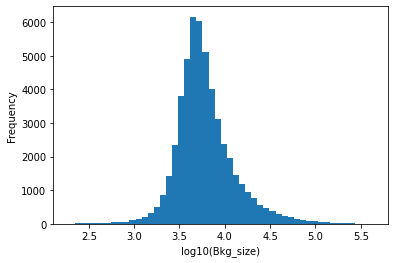

In [8]:
Original_labels['Bkg_size'].apply(np.log10).plot.hist(bins=50)
plt.xlabel('log10(Bkg_size)')

In [9]:
Original_labels['Bkg_size'].describe()

count     50930.000000
mean       8754.953872
std       13890.621081
min         189.195364
25%        3898.289539
50%        5427.521359
75%        8444.426704
max      429717.366276
Name: Bkg_size, dtype: float64

It seems that statistically we will have enough pixels to extract the noise for most of the original images. But what about downscaled images

In [10]:
downscaling_factor=np.ones(len(Labels))
downscaling_factor[Labels['Original_R_cut']>64]=64/Labels['Original_R_cut'][Labels['Original_R_cut']>64]
def downscale(series):
    return np.ceil(series*downscaling_factor)


Downscaled_labels=Labels[['Original_R_cut', 'Original_x_size','Original_y_size']].apply(downscale)
Downscaled_labels.columns=['Downscaled_R_cut', 'Downscaled_x_size','Downscaled_y_size']
Downscaled_labels[['Sersic_q','Sersic_phi']]=Labels[['Sersic_q','Sersic_phi']]

Downscaled_labels['Bkg_x_size']=Downscaled_labels['Downscaled_x_size']-2*Downscaled_labels['Downscaled_R_cut']*np.cos(Original_labels['Sersic_phi'])
Downscaled_labels['Bkg_y_size']=Downscaled_labels['Downscaled_y_size']-np.ceil(2*Downscaled_labels['Downscaled_R_cut']*Downscaled_labels['Sersic_q']*np.abs(np.sin(Original_labels['Sersic_phi'])))

Downscaled_labels['Bkg_size']=Downscaled_labels['Bkg_x_size']*Downscaled_labels['Bkg_y_size']
Downscaled_labels.head()

,Downscaled_R_cut,Downscaled_x_size,Downscaled_y_size,Sersic_q,Sersic_phi,Bkg_x_size,Bkg_y_size,Bkg_size
COSMOS_index,,,,,,,,
0,64.0,174.0,174.0,0.432521,1.497915,164.679434,118.0,19432.173220
1,48.0,146.0,146.0,0.680755,1.344840,124.492300,82.0,10208.368605
2,24.0,94.0,94.0,0.704077,-0.994134,67.828997,65.0,4408.884792
3,49.0,146.0,146.0,0.622182,-1.014131,94.220921,94.0,8856.766582
4,19.0,90.0,90.0,0.877553,1.544308,88.993548,56.0,4983.638694


In [11]:
print('Fraction of scaled galaxies {:.2f}'.format(len(Downscaled_labels[Downscaled_labels.Downscaled_R_cut==64])/len(Downscaled_labels)))

Fraction of scaled galaxies 0.11


Text(0.5, 0, 'log10(Bkg_size)')

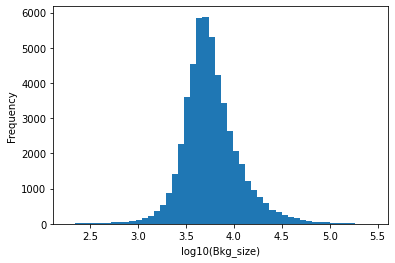

In [12]:
Downscaled_labels['Bkg_size'].apply(np.log10).plot.hist(bins=50)
plt.xlabel('log10(Bkg_size)')

In [13]:
Downscaled_labels['Bkg_size'].describe()

count     50930.000000
mean       7759.831618
std       10073.727833
min         189.195364
25%        3859.707017
50%        5345.661532
75%        8067.858815
max      282289.395202
Name: Bkg_size, dtype: float64

It is questionable how significant is value of sigma estimated on 189 pixels for the 64x64 image.

## Technique of noise extraction

In [14]:
#Using elliptical representation of galaxy extract galaxy-free regions
#That we can use for noise estimation
def get_Background_image(image,R_cut,Ellipticity,Angle):
    
    (y_size,x_size)=image.shape
    R_cut=np.minimum(R_cut,np.minimum(y_size,x_size))
    
    #Offsets from image borders that cover noise regions
    Bkg_x_offset=np.floor(x_size//2-R_cut*np.cos(Angle)).astype(int)
    Bkg_y_offset=np.floor(y_size//2-R_cut*Ellipticity*np.abs(np.sin(Angle))).astype(int)
    Bkg_image=np.zeros((2*Bkg_y_offset,2*Bkg_x_offset))
    
    #Extract 4 diagonal border regions to estimate backgroud noise
    #Upper left
    Bkg_image[:Bkg_y_offset,:Bkg_x_offset]=image[:Bkg_y_offset,:Bkg_x_offset]
    #Upper right
    Bkg_image[:Bkg_y_offset,-Bkg_x_offset:]=image[:Bkg_y_offset,-Bkg_x_offset:]
    #Lower left
    Bkg_image[-Bkg_y_offset:,:Bkg_x_offset]=image[-Bkg_y_offset:,:Bkg_x_offset]
    #Lower right
    Bkg_image[-Bkg_y_offset:,-Bkg_x_offset:]=image[-Bkg_y_offset:,-Bkg_x_offset:]
    
    return Bkg_image

'''
skimage.restoration.estimate_sigma
[1] D. L. Donoho and I. M. Johnstone. "Ideal spatial adaptation 
by wavelet shrinkage." Biometrika 81.3 (1994): 425-455.
       :DOI:`10.1093/biomet/81.3.425`
'''
def estimate_sigma(Background_image):
    
    coeffs = pywt.dwtn(Background_image, wavelet='db2')
    detail_coeffs = coeffs['d' * Background_image.ndim]

    # Consider regions with detail coefficients exactly zero to be masked out
    detail_coeffs = detail_coeffs[np.nonzero(detail_coeffs)]

    # 75th quantile of the underlying, symmetric noise distribution
    denom = norm.ppf(0.75)
    return np.median(np.abs(detail_coeffs)) / denom

# Verify COSMOS parameters usability

## Noise

In [61]:
import statsmodels.api as sm
import seaborn as sns
import scipy


def analyse_scatterplot(x,y):
    
    
    endog = y
    exog = sm.add_constant(x)
    
    #envoke a model that predicts label by all the demographic features
    mod = sm.OLS(endog, exog)
    res = mod.fit()

    #Transform results with LR coefficients to DataFrame
    results_as_html = res.summary().tables[1].as_html()
    df_summary=pd.read_html(results_as_html, header=0, index_col=0)[0]
    
    #Consider only significant coefficients
    return df_summary[df_summary['P>|t|']<0.05][['coef', 'std err', 'P>|t|']]

In [15]:
'''sigmas=np.zeros((1000,2))
for i in tqdm(range(1000)):
    index=int(np.random.choice(Labels.index.to_numpy()))
    
    #estimated noise
    gal,COSMOS_noise,COSMOS_ellipticity,COSMOS_angle=get_galaxy(index)
    image=gal.drawImage(use_true_center=True, method='auto').array
    Bkg_image=get_Background_image(image,*Labels[['Original_R_cut','Sersic_q','Sersic_phi']].loc[index])
    estimated_noise=estimate_sigma(Bkg_image)
    
    sigmas[i]=[COSMOS_noise/image.max(),estimated_noise/image.max()]'''

100%|██████████| 1000/1000 [00:54<00:00, 18.42it/s]


In [19]:
#df_sigmas=pd.DataFrame(sigmas,columns=['COSMOS noise','MAD estimated noise'])
#df_sigmas.to_csv('Test data/Sigmas_test.csv')
df_sigmas=pd.read_csv('Test data/Sigmas_test.csv',index_col=0)
df_sigmas.head()

,COSMOS noise,MAD estimated noise
0,0.056336,0.015970
1,0.032430,0.008100
2,0.001842,0.000517
3,0.055290,0.019811
4,0.057879,0.029754


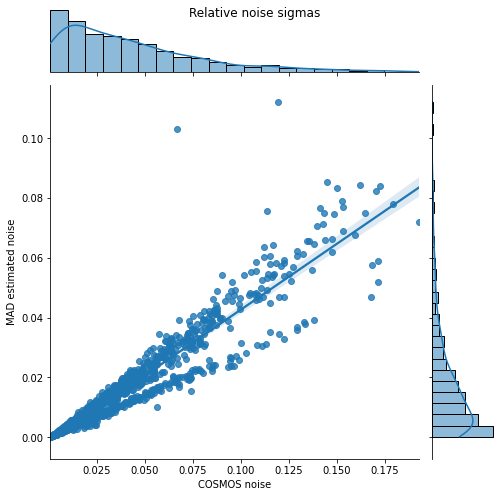

SpearmanrResult(correlation=0.9729149407524306, pvalue=0.0)


,coef,std err,P>|t|
const,-0.0013,0.000,0.0
COSMOS noise,0.4394,0.005,0.0


In [62]:
X=df_sigmas['COSMOS noise']
y=df_sigmas['MAD estimated noise']

g=sns.jointplot(x=X,y=y,kind="reg",height=7)
g.fig.suptitle('Relative noise sigmas')
plt.show()

print(scipy.stats.spearmanr(X,y))
analyse_scatterplot(X,y)

We see that the estimated noise and the extracted one are correlated, however COSMOS tends to overestimate noise by a factor of 2. Moreover the scatterplot has a clear structure of two branches, which is very strange.
The contant in linear regression has almost negligible value.

COSMOS_noise/2 can be used as a first approximation of Estimated noise.

## COSMOS Ellipticities and angles

In [96]:
ellipt=np.zeros((1000,2))
angle=np.zeros((1000,2))
for i in tqdm(range(1000)):
    index=int(np.random.choice(Labels.index.to_numpy()))
    
    #estimated noise
    gal,COSMOS_noise,COSMOS_ellipticity,COSMOS_angle=get_galaxy(index)
    
    #Adjust COSMOS noise according to previous section
    COSMOS_noise/=2
    
    original_image=gal.drawImage(use_true_center=True, method='auto').array
    Sersic_fit,_=Image_Fits_Stats.fit_image(original_image,profile_type='Sersic',noise_std=COSMOS_noise,exposure_time=2028)
    q,x0,y0,phi=Sersic_fit[-4:]
    
    ellipt[i]=[COSMOS_ellipticity,q]
    angle[i]=[COSMOS_angle,phi]

100%|██████████| 1000/1000 [05:07<00:00,  3.26it/s]


In [100]:
'''df_ellipt=pd.DataFrame(ellipt,columns=['COSMOS q','Estimated q'])
df_phi=pd.DataFrame(angle,columns=['COSMOS phi','Estimated phi'])
df_ellipt.to_csv('Test data/Ellipt.csv')
df_phi.to_csv('Test data/Angle.csv')'''

In [101]:
df_ellipt=pd.read_csv('Test data/Ellipt.csv',index_col=0)
df_phi=pd.read_csv('Test data/Angle.csv',index_col=0)

### Ellipticities

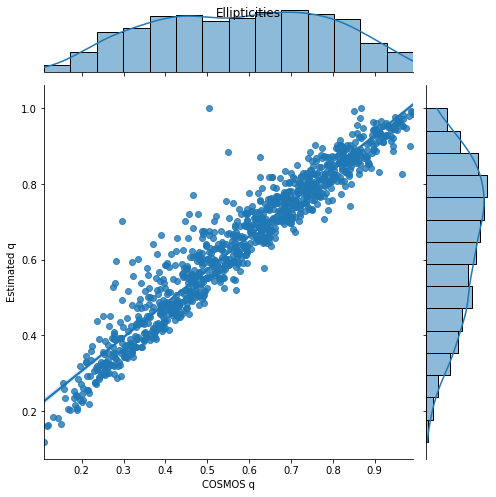

SpearmanrResult(correlation=0.9622362131032995, pvalue=0.0)


,coef,std err,P>|t|
const,0.1284,0.005,0.0
COSMOS q,0.8895,0.008,0.0


In [104]:
X=df_ellipt['COSMOS q']
y=df_ellipt['Estimated q']

g=sns.jointplot(x=X,y=y,kind="reg",height=7)
g.fig.suptitle('Ellipticities')
plt.show()

print(scipy.stats.spearmanr(X,y))
analyse_scatterplot(X,y)

In general, the values seem good, but bias of 0.13 for q from [0,1] is too much 

### Angles

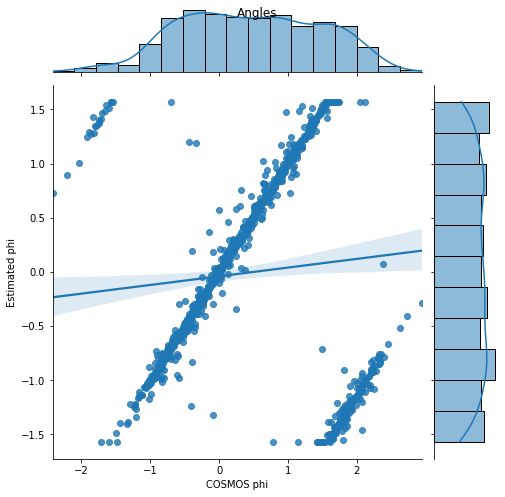

SpearmanrResult(correlation=0.12626686349380264, pvalue=6.229351936060729e-05)


,coef,std err,P>|t|
COSMOS phi,0.0803,0.029,0.005


In [105]:
X=df_phi['COSMOS phi']
y=df_phi['Estimated phi']

g=sns.jointplot(x=X,y=y,kind="reg",height=7)
g.fig.suptitle('Angles')
plt.show()

print(scipy.stats.spearmanr(X,y))
analyse_scatterplot(X,y)

In [109]:
print('COSMOS phi borders {:.2f} {:.2f}'.format(df_phi['COSMOS phi'].min(),df_phi['COSMOS phi'].max()))

COSMOS phi borders -2.42 2.94


Seems that they used Sersic angle from [-pi,pi], which has no point given the fact that Sersic fit is symmetrical. The values can be brought to [-pi/2,pi/2] for unambiguity.

In [107]:
df_phi_correct=df_phi.copy()
df_phi_correct.loc[df_phi['COSMOS phi']<-np.pi/2,'COSMOS phi']=df_phi[df_phi['COSMOS phi']<-np.pi/2]['COSMOS phi']+np.pi
df_phi_correct.loc[df_phi['COSMOS phi']>np.pi/2,'COSMOS phi']=df_phi[df_phi['COSMOS phi']>np.pi/2]['COSMOS phi']-np.pi

In [110]:
print('Correct COSMOS phi borders {:.2f} {:.2f}'.format(df_phi_correct['COSMOS phi'].min(),df_phi_correct['COSMOS phi'].max()))

Correct COSMOS phi borders -1.57 1.57


In [114]:
#df_phi_correct.to_csv('Test data/Angle_correct.csv')

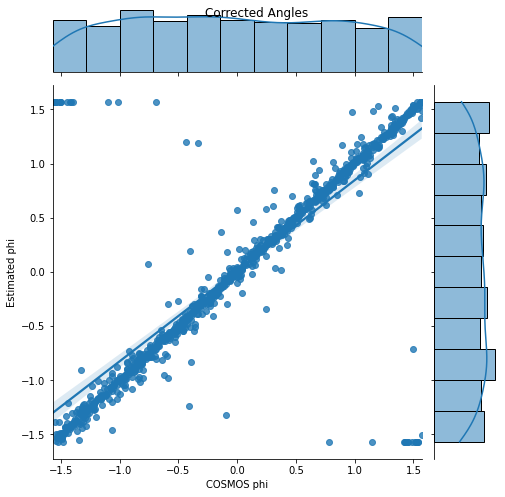

SpearmanrResult(correlation=0.8239485986455776, pvalue=2.0209212241995686e-248)


,coef,std err,P>|t|
COSMOS phi,0.8371,0.018,0.0


In [111]:
X=df_phi_correct['COSMOS phi']
y=df_phi_correct['Estimated phi']

g=sns.jointplot(x=X,y=y,kind="reg",height=7)
g.fig.suptitle('Corrected Angles')
plt.show()

print(scipy.stats.spearmanr(X,y))
analyse_scatterplot(X,y)

Constant is insignificant and if we neglect outliers we receive a perfect linear dependency.
However, there are outliers, that look like some random descrepancies. There can be two explanations:

    1. Angles near -pi/2 and pi/2 are almost identical. Therefore, discrepancy with value near pi is not a problem
    2. For elliptical galaxies with e->1 it is difficult to determine the angle. Although, the angle becomes less and less important as we approach to e->1, so it is not a major problem either. 

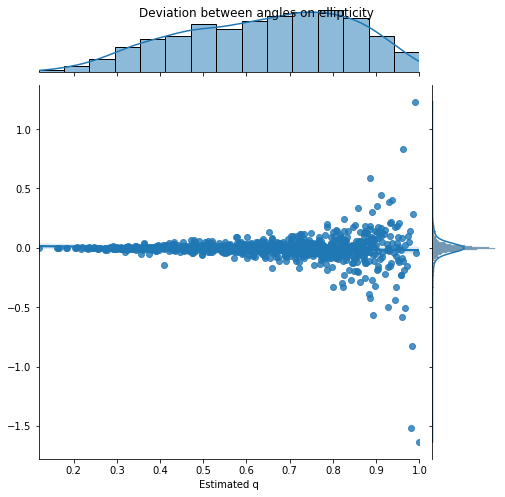

In [113]:
angle_deviations=df_phi_correct['COSMOS phi']-df_phi_correct['Estimated phi']
Mask=np.abs(angle_deviations)<2
g=sns.jointplot(x=df_ellipt[Mask]['Estimated q'], y=angle_deviations[Mask],
                  kind="reg",height=7)
g.fig.suptitle('Deviation between angles on ellipticity')
plt.show()

Indeed, the higher is ellipticity, the more is angle discrepancy. 

Conclusion. The parameters of a galaxy provided by COSMOS dataset can be considered reliable.

# Fit image using Exposure time and estimated noise

In [28]:
cat.getParametricRecord(0)

{'IDENT': 141190,
 'mag_auto': 21.04064178466797,
 'flux_radius': 27.871679306030273,
 'zphot': 0.19499999284744263,
 'sersicfit': array([1.33632217e-02, 4.13907911e+01, 1.14539305e+00, 3.20145619e-01,
        0.00000000e+00, 2.47237359e+02, 2.51852802e+02, 1.64981541e+00]),
 'bulgefit': array([1.20382532e-02, 4.15108632e+01, 1.00000000e+00, 3.51039782e-01,
        0.00000000e+00, 2.47249777e+02, 2.51840007e+02, 1.63242231e+00,
        4.27921802e-03, 3.82518029e+01, 4.00000000e+00, 5.00000000e-02,
        0.00000000e+00, 2.47249777e+02, 2.51840007e+02, 1.69868752e+00]),
 'fit_status': array([1, 1, 1, 1, 1], dtype=int32),
 'fit_mad_s': 0.00292345408682618,
 'fit_mad_b': 0.002849912063753065,
 'fit_dvc_btt': 0.07225554208583779,
 'use_bulgefit': 0,
 'viable_sersic': 1,
 'hlr': array([0.70258482, 0.        , 0.        ]),
 'flux': array([92.8869769,  0.       ,  0.       ,  0.       ])}

In [30]:
def renorm_angle(angle):
    if angle<-np.pi/2:
        angle+=np.pi
    elif angle>np.pi/2:
        angle-=np.pi
    return angle

def get_COSMOS_Sersic_fit(shape,test_galaxy_index):
    COSMOS_I,COSMOS_HLR,COSMOS_n,COSMOS_q,COSMOS_b,_,_,COSMOS_angle=cat.getParametricRecord(test_galaxy_index)['sersicfit']
    if cat.getParametricRecord(test_galaxy_index)['use_bulgefit']:
        bulgefit=cat.getParametricRecord(test_galaxy_index)['bulgefit']
        COSMOS_q=bulgefit[3]
        COSMOS_angle=bulgefit[7]
        
    #Bring it to [-pi/2,pi/2]
    COSMOS_angle=renorm_angle(COSMOS_angle)
        
    COSMOS_y0=shape[0]/2
    COSMOS_x0=shape[1]/2
    
    return [COSMOS_I,COSMOS_HLR,COSMOS_n,COSMOS_q,COSMOS_x0,COSMOS_y0,COSMOS_angle]

def overview_fit_and_background(test_galaxy_index):
    gal,COSMOS_noise,COSMOS_ellipticity,COSMOS_angle=get_galaxy(test_galaxy_index)
    
    #Adjust COSMOS noise according to the section about COSMOS noise
    COSMOS_noise/=2
    

    
    original_image=gal.drawImage(use_true_center=True, method='auto').array
    fit,_=Image_Fits_Stats.fit_image(original_image,profile_type='Sersic')
    I,HLR,n,q,x0,y0,phi=fit
    fit_image=get_fit_image(original_image,fit,profile_type='Sersic')
    

    COSMOS_Sersic_fit=get_COSMOS_Sersic_fit(original_image.shape,test_galaxy_index)
    fit_image2=get_fit_image(original_image,COSMOS_Sersic_fit,profile_type='Sersic')

    Bkg_image=get_Background_image(original_image,*Original_labels[['Original_R_cut','Sersic_q','Sersic_phi']].iloc[test_galaxy_index])


    print('Point SNR {:.2f}'.format(original_image.max()/estimate_sigma(Bkg_image)))

    f, ax = plt.subplots(1, 4, figsize=(15,10))
    ax[0].imshow(original_image)
    ax[0].set_title("Original image")
    
    ax[1].imshow(fit_image)
    ax[1].set_title('Sersic fit')
    
    ax[2].imshow(fit_image2)
    ax[2].set_title('COSMOS Sersic fit')
    
    ax[3].imshow(Bkg_image)
    ax[3].set_title('Background')
    plt.show()
    
    return (q,phi),(COSMOS_ellipticity,COSMOS_angle)

In [26]:
df_test=Labels[['COSMOS_use_bulgefit','COSMOS_Disk_phi', 'COSMOS_Disk_q','COSMOS_Sersic_phi']].iloc[test_galaxies_indices]
df_test['COSMOS_Sersic_phi']=df_test['COSMOS_Sersic_phi'].apply(renorm_angle)
df_test['COSMOS_Disk_phi']=df_test['COSMOS_Disk_phi'].apply(renorm_angle)
df_test

,COSMOS_use_bulgefit,COSMOS_Disk_phi,COSMOS_Disk_q,COSMOS_Sersic_phi
COSMOS_index,,,,
518,1.0,-1.564815,0.443915,-1.331744
33673,1.0,-1.146630,0.847518,-0.848297
25578,0.0,-0.581295,0.788394,-0.583991
45807,1.0,1.396592,0.560908,0.197485
31579,0.0,1.359031,0.262583,1.360479
41709,0.0,-0.959515,0.875313,-0.830863
19846,0.0,-0.656741,0.416127,-0.662418
13630,0.0,-0.220551,0.162122,-0.730341
8626,0.0,0.431762,0.915204,-0.512686


In [18]:
test_galaxies_indices

[518, 33671, 25576, 45805, 31577, 41707, 19844, 13628, 8624]

Point SNR 849.27


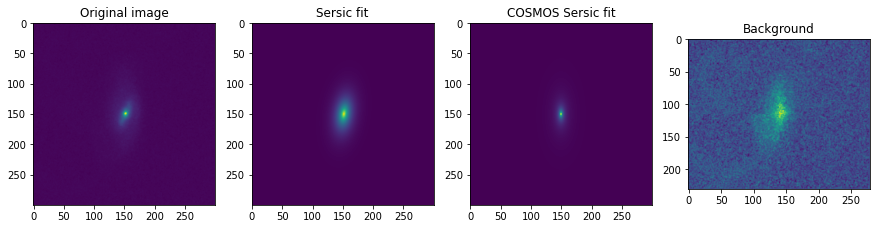

Point SNR 466.32


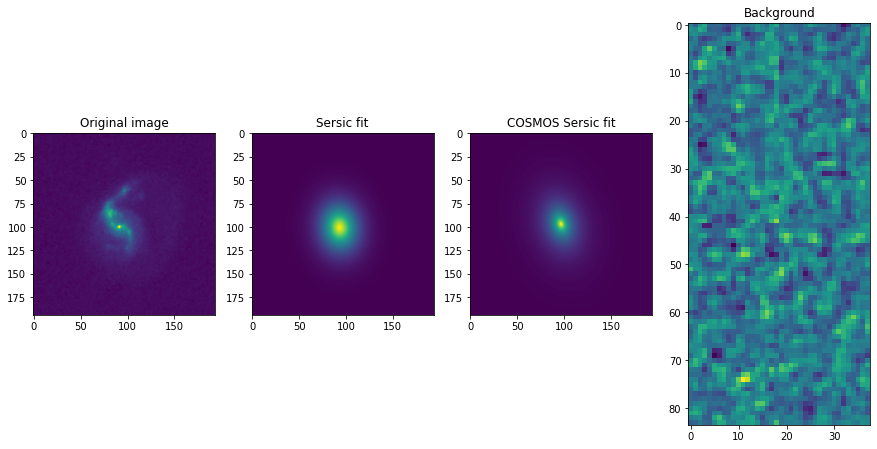

Point SNR 511.26


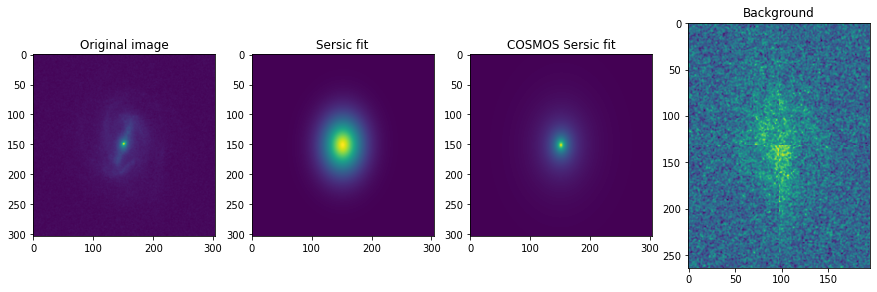

Point SNR 263.11


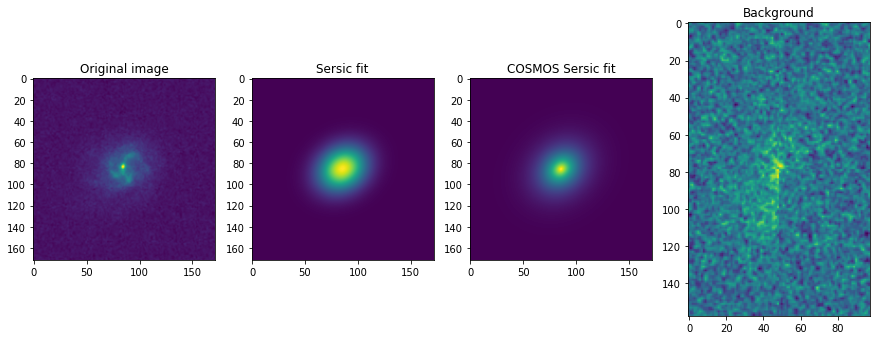

Point SNR 199.86


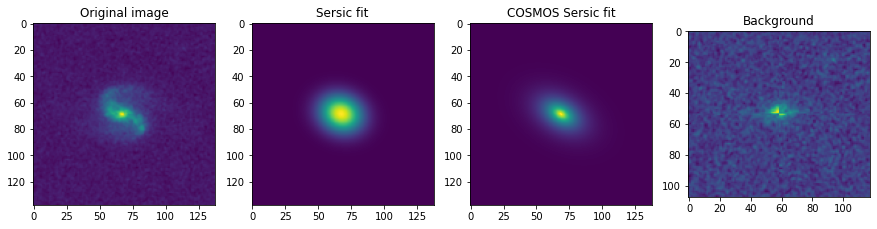

Point SNR 920.21


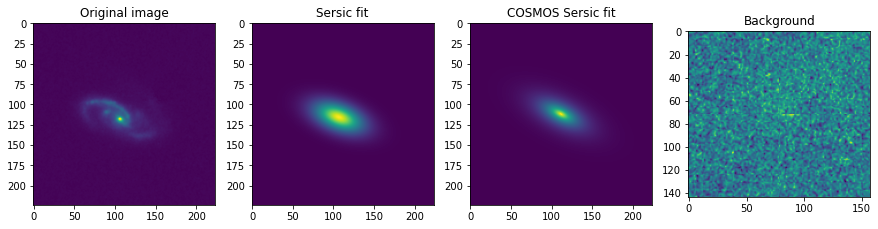

Point SNR 397.44


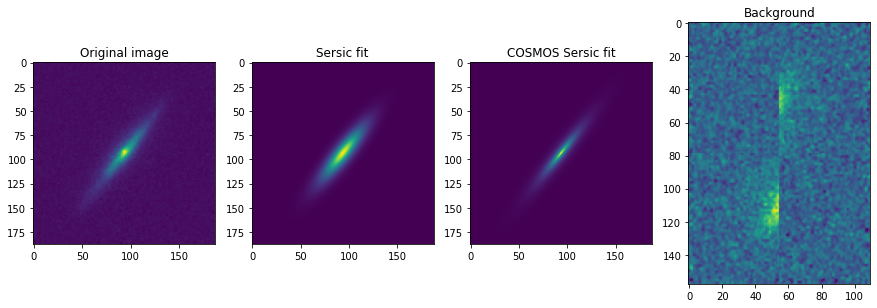

Point SNR 482.40


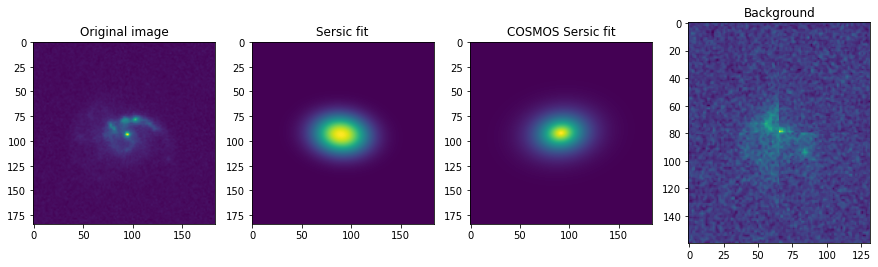

Point SNR 110.16


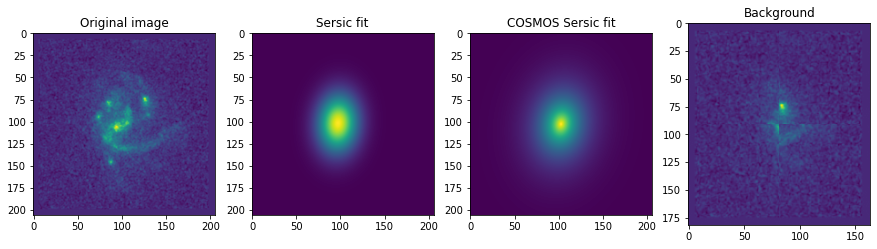

In [31]:
for i in range(9):
    overview_fit_and_background(test_galaxies_indices[i])

Seems that COSMOS Ellipticity and Angles are better than I get with my fitting

# Radial profile

In [77]:
def get_R_cut(image,q,x0,y0,phi,Radial_profile_threshold=0.01):
    Radial_profile=Image_Fits_Stats.Radial_profile(image,q,x0,y0,phi)
    
    #Getting border of galaxy from radial profile
    Radial_profile=Radial_profile-Radial_profile[-1]
    Radial_profile/=Radial_profile.max()
    R_cut=np.where((Radial_profile<Radial_profile_threshold))[0][0]
    return R_cut

def overview_cut_methods(test_galaxy_index
                        ):
    gal,COSMOS_noise,COSMOS_ellipticity,COSMOS_angle=get_galaxy(test_galaxy_index)
    
    
    original_image=gal.drawImage(use_true_center=True, method='auto').array
    Sersic_fit,_=Image_Fits_Stats.fit_image(original_image,profile_type='Sersic')
    R_cut_Self=get_R_cut(original_image,*Sersic_fit[-4:])
    
    COSMOS_Sersic_fit=get_COSMOS_Sersic_fit(original_image.shape,test_galaxy_index)
    print(COSMOS_Sersic_fit)
    print(Sersic_fit)
    COSMOS_Sersic_fit[-3]=Sersic_fit[-3]
    COSMOS_Sersic_fit[-2]=Sersic_fit[-2]
    R_cut_COSMOS=get_R_cut(original_image,*COSMOS_Sersic_fit[-4:])
    
    f, ax = plt.subplots(1, 3, figsize=(15,10))
    ax[0].imshow(original_image)
    ax[0].set_title("Original image")
    
    q,x0,y0,phi=Sersic_fit[-4:]
    x0=round(x0)
    y0=round(y0)
    R_cut_Self=np.minimum(np.min(original_image.shape)//2,R_cut_Self)
    ax[1].imshow(original_image[x0-R_cut_Self:x0+R_cut_Self,y0-R_cut_Self:y0+R_cut_Self])
    ax[1].set_title('Radial cut %d' % R_cut_Self)
    
    q,x0,y0,phi=COSMOS_Sersic_fit[-4:]
    x0=round(x0)
    y0=round(y0)
    R_cut_COSMOS=np.minimum(np.min(original_image.shape)//2,R_cut_COSMOS)
    ax[2].imshow(original_image[x0-R_cut_COSMOS:x0+R_cut_COSMOS,y0-R_cut_COSMOS:y0+R_cut_COSMOS])
    ax[2].set_title('COSMOS R_cut %d' % R_cut_COSMOS)
    plt.show()

In [81]:
Labels.loc[test_galaxies_indices[4]]['Original_R_cut']

38.0

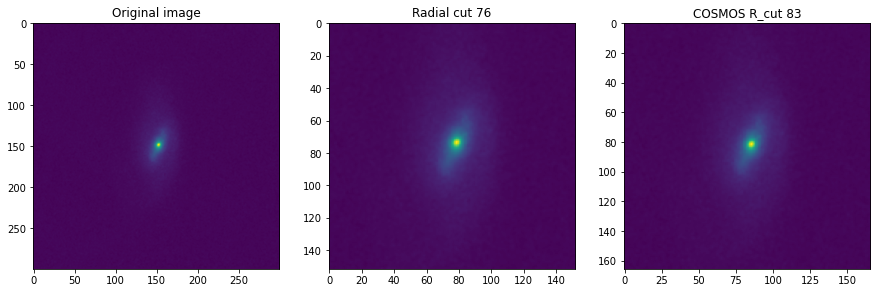

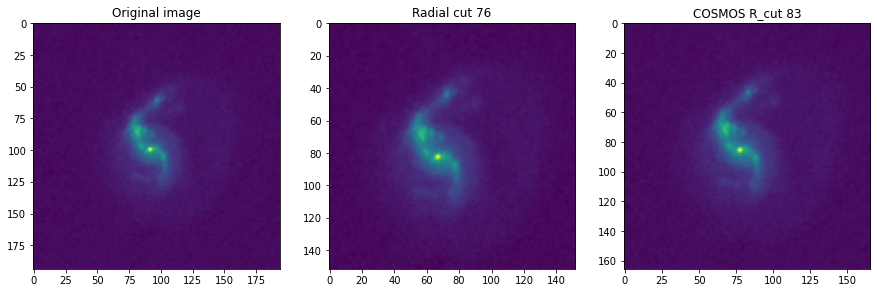

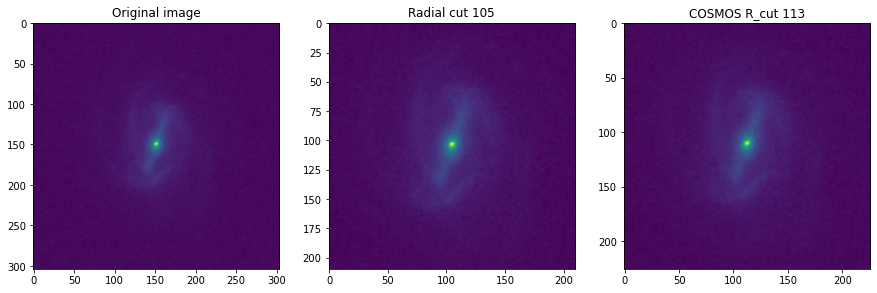

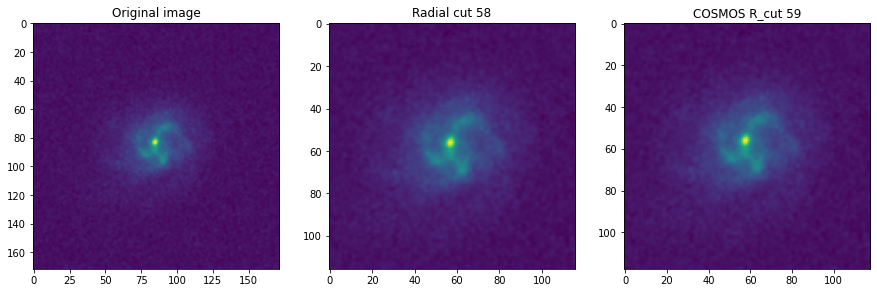

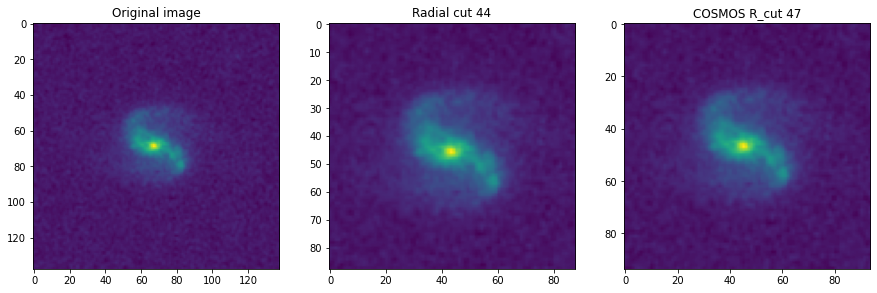

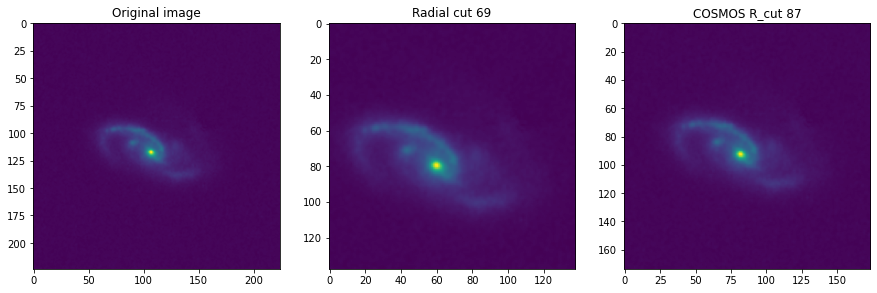

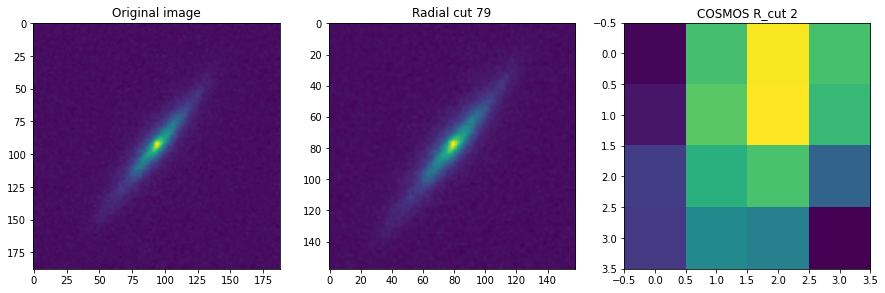

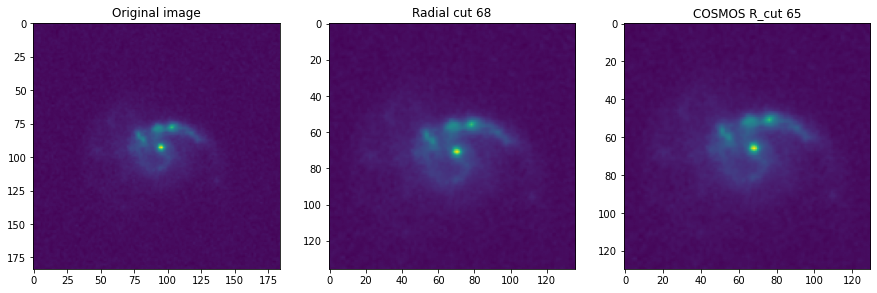

In [70]:
for i in range(9):
    overview_cut_methods(test_galaxies_indices[i])

Seems that in my approach galaxy in final image can be shifted. Definition of size, though is better. 

COSMOS fails with x0,y0. And if we rely on shape/2, we get super weird results. One still needs to make Sersic fit to get x0,y0. The only thing is that I can fix **phi** or **phi** and **q** on values corresponding to COSMOS.

[0.06296428643193484, 31.615128284046726, 1.1322781198752074, 0.18958563465343983, 94.0, 94.0, -0.8969674148767421]
[ 6.75109196e-02  2.79666931e+01  6.83372753e-01  2.39726475e-01
  9.39658172e+01  9.37729642e+01 -9.01927045e-01]


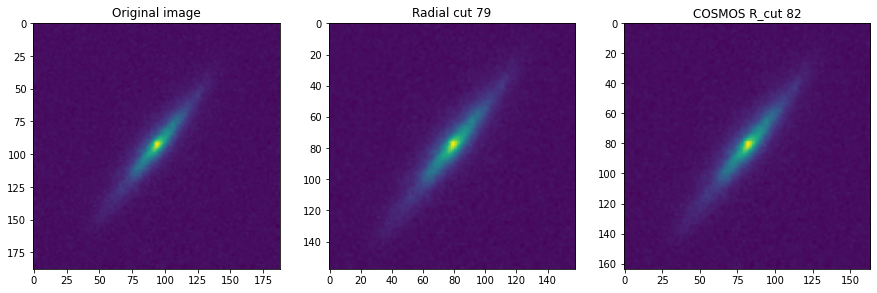

In [78]:
overview_cut_methods(test_galaxies_indices[6])